In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
# Data loading
path = r'../data/processed/data_processed_v1.csv'
df_processed = pd.read_csv(path)

In [7]:
print(df_processed.info())
df_processed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18304 entries, 0 to 18303
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Año      18304 non-null  int64  
 1   Semana   18304 non-null  int64  
 2   Fecha    18304 non-null  object 
 3   Entidad  18304 non-null  object 
 4   Año_Epi  18304 non-null  int64  
 5   H        18304 non-null  float64
 6   M        18304 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1001.1+ KB
None


,Año,Semana,Fecha,Entidad,Año_Epi,H,M
0,2014,2,2014-01-13,Aguascalientes,2014,0.0,0.0
1,2014,3,2014-01-20,Aguascalientes,2014,0.0,0.0
2,2014,4,2014-01-27,Aguascalientes,2014,0.0,0.0
3,2014,5,2014-02-03,Aguascalientes,2014,0.0,0.0
4,2014,6,2014-02-10,Aguascalientes,2014,0.0,0.0


## Baseline

In [10]:
# ==================================================
# 1. PREPARAR DATOS
# ==================================================

df = df_processed.copy()
# Convertir Fecha a datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])
# Ordenar por fecha
df = df.sort_values(['Entidad', 'Fecha']).reset_index(drop=True)

In [11]:
# Calcular casos acumulados totales
df['Casos_acumulados'] = df['H'] + df['M']

# Calcular casos nuevos por entidad
df['Casos_nuevos'] = df.groupby('Entidad')['Casos_acumulados'].diff()

# Para primera semana de cada entidad, casos nuevos = casos acumulados
primera_semana_mask = df.groupby('Entidad').cumcount() == 0
df.loc[primera_semana_mask, 'Casos_nuevos'] = df.loc[primera_semana_mask, 'Casos_acumulados']

# Para semana 2 (reinicio del año), casos nuevos = casos acumulados
semana2_mask = df['Semana'] == 2
df.loc[semana2_mask, 'Casos_nuevos'] = df.loc[semana2_mask, 'Casos_acumulados']

# Asegurar no negativos
df['Casos_nuevos'] = df['Casos_nuevos'].clip(lower=0)

print("Datos preparados:")
print(df[['Fecha', 'Entidad', 'Casos_nuevos']].head(10))
print(f"\nTotal de registros: {len(df)}")

Datos preparados:
       Fecha         Entidad  Casos_nuevos
0 2014-01-13  Aguascalientes           0.0
1 2014-01-20  Aguascalientes           0.0
2 2014-01-27  Aguascalientes           0.0
3 2014-02-03  Aguascalientes           0.0
4 2014-02-10  Aguascalientes           0.0
5 2014-02-17  Aguascalientes           0.0
6 2014-02-24  Aguascalientes           0.0
7 2014-03-03  Aguascalientes           0.0
8 2014-03-10  Aguascalientes           0.0
9 2014-03-17  Aguascalientes           0.0

Total de registros: 18304


In [12]:
# ==================================================
# 2. AGREGAR DATOS A NIVEL NACIONAL
# ==================================================

# Sumar casos de todas las entidades por semana
df_mexico = df.groupby(['Fecha', 'Año', 'Semana']).agg({
    'Casos_nuevos': 'sum',
    'H': 'sum',
    'M': 'sum'
}).reset_index()

df_mexico = df_mexico.sort_values('Fecha').reset_index(drop=True)

print(f"\nDatos agregados a nivel nacional:")
print(f"Total de semanas: {len(df_mexico)}")
print(f"Periodo: {df_mexico['Fecha'].min()} a {df_mexico['Fecha'].max()}")
print(f"\nEstadísticas de casos nuevos:")
print(df_mexico['Casos_nuevos'].describe())


Datos agregados a nivel nacional:
Total de semanas: 572
Periodo: 2014-01-13 00:00:00 a 2024-12-23 00:00:00

Estadísticas de casos nuevos:
count     572.000000
mean       51.337413
std        88.076108
min         0.000000
25%        37.000000
50%        48.000000
75%        57.000000
max      2118.000000
Name: Casos_nuevos, dtype: float64


In [13]:
# ==================================================
# 3. DIVISIÓN TRAIN/TEST (80/20)
# ==================================================

split_idx = int(len(df_mexico) * 0.8)
train = df_mexico[:split_idx].copy()
test = df_mexico[split_idx:].copy()

print("\n" + "="*60)
print("DIVISIÓN TRAIN/TEST")
print("="*60)
print(f"Train: {len(train)} semanas ({train['Fecha'].min().strftime('%Y-%m-%d')} a {train['Fecha'].max().strftime('%Y-%m-%d')})")
print(f"Test:  {len(test)} semanas ({test['Fecha'].min().strftime('%Y-%m-%d')} a {test['Fecha'].max().strftime('%Y-%m-%d')})")
print(f"\nCasos promedio en train: {train['Casos_nuevos'].mean():.2f}")
print(f"Casos promedio en test: {test['Casos_nuevos'].mean():.2f}")


DIVISIÓN TRAIN/TEST
Train: 457 semanas (2014-01-13 a 2022-10-03)
Test:  115 semanas (2022-10-10 a 2024-12-23)

Casos promedio en train: 52.27
Casos promedio en test: 47.63


In [14]:
# ==================================================
# 4. MODELO NAIVE FORECAST (BASELINE)
# ==================================================

# Naive: la predicción de la semana t+1 es el valor de la semana t
test = test.copy()
test['Prediccion_naive'] = test['Casos_nuevos'].shift(1)

# Para la primera predicción del test, usar el último valor del train
test.loc[test.index[0], 'Prediccion_naive'] = train['Casos_nuevos'].iloc[-1]

print("\n" + "="*60)
print("PREDICCIONES NAIVE (Primeras 10 semanas del test)")
print("="*60)
print(test[['Fecha', 'Casos_nuevos', 'Prediccion_naive']].head(10).to_string(index=False))



PREDICCIONES NAIVE (Primeras 10 semanas del test)
     Fecha  Casos_nuevos  Prediccion_naive
2022-10-10          61.0              58.0
2022-10-17          46.0              61.0
2022-10-24          76.0              46.0
2022-10-31          54.0              76.0
2022-11-07          45.0              54.0
2022-11-14          44.0              45.0
2022-11-21          56.0              44.0
2022-11-28          35.0              56.0
2022-12-05          40.0              35.0
2022-12-12          42.0              40.0


In [16]:
# ==================================================
# 5. MÉTRICAS DE EVALUACIÓN
# ==================================================

y_true = test['Casos_nuevos'].values
y_pred = test['Prediccion_naive'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100  # +1e-10 para evitar división por cero

print("\n" + "="*60)
print("RESULTADOS DEL BASELINE (NAIVE FORECAST)")
print("="*60)
print(f"MAE (Mean Absolute Error):  {mae:.2f} casos")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} casos")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"\nContexto:")
print(f"  Promedio de casos nuevos reales: {y_true.mean():.2f}")
print(f"  Desviación estándar: {y_true.std():.2f}")
print(f"  Error promedio como % del promedio: {(mae / y_true.mean() * 100):.1f}%")



RESULTADOS DEL BASELINE (NAIVE FORECAST)
MAE (Mean Absolute Error):  10.57 casos
RMSE (Root Mean Squared Error): 15.18 casos
MAPE (Mean Absolute Percentage Error): 22.51%

Contexto:
  Promedio de casos nuevos reales: 47.63
  Desviación estándar: 13.04
  Error promedio como % del promedio: 22.2%


In [17]:
# ==================================================
# 6. COMPARACIÓN CON MODELO ALEATORIO
# ==================================================

# Baseline del baseline: predicción aleatoria uniforme
np.random.seed(42)
random_baseline = np.random.uniform(y_true.min(), y_true.max(), size=len(y_true))
mae_random = mean_absolute_error(y_true, random_baseline)
rmse_random = np.sqrt(mean_squared_error(y_true, random_baseline))

print("\n" + "="*60)
print("COMPARACIÓN CON MODELO ALEATORIO")
print("="*60)
print(f"MAE Random:  {mae_random:.2f} casos")
print(f"RMSE Random: {rmse_random:.2f} casos")
print(f"\nMejora del Naive sobre Aleatorio:")
print(f"  MAE:  {((mae_random - mae) / mae_random * 100):.1f}% mejor")
print(f"  RMSE: {((rmse_random - rmse) / rmse_random * 100):.1f}% mejor")


COMPARACIÓN CON MODELO ALEATORIO
MAE Random:  25.04 casos
RMSE Random: 30.61 casos

Mejora del Naive sobre Aleatorio:
  MAE:  57.8% mejor
  RMSE: 50.4% mejor


In [18]:
# ==================================================
# 7. EVALUACIÓN: ¿Está sobreajustando?
# ==================================================

print("\n" + "="*60)
print("ANÁLISIS DE AJUSTE")
print("="*60)
print("El modelo Naive NO puede sobreajustar porque:")
print("  - No tiene parámetros que aprender")
print("  - No entrena sobre los datos")
print("  - Simplemente copia el valor anterior")
print("\nEsto lo hace el baseline perfecto para establecer")
print("el desempeño mínimo esperado.")



ANÁLISIS DE AJUSTE
El modelo Naive NO puede sobreajustar porque:
  - No tiene parámetros que aprender
  - No entrena sobre los datos
  - Simplemente copia el valor anterior

Esto lo hace el baseline perfecto para establecer
el desempeño mínimo esperado.


In [19]:
# ==================================================
# 8. DESEMPEÑO MÍNIMO ACEPTABLE
# ==================================================

print("\n" + "="*60)
print("DESEMPEÑO MÍNIMO ACEPTABLE")
print("="*60)
print(f"Baseline actual (Naive): MAE = {mae:.2f}, MAPE = {mape:.2f}%")
print(f"\nCualquier modelo futuro debe:")
print(f"  1. Superar MAE < {mae:.2f} casos")
print(f"  2. Superar MAPE < {mape:.2f}%")
print(f"\nInterpretación:")
if mape < 20:
    print("  ✓ MAPE < 20%: El baseline es razonablemente bueno")
    print("    Los datos tienen patrones predecibles")
elif mape < 35:
    print("  ⚠ MAPE entre 20-35%: Baseline moderado")
    print("    Hay margen significativo de mejora con modelos complejos")
else:
    print("  ⚠ MAPE > 35%: Baseline débil")
    print("    Alta variabilidad - se requieren modelos sofisticados")


DESEMPEÑO MÍNIMO ACEPTABLE
Baseline actual (Naive): MAE = 10.57, MAPE = 22.51%

Cualquier modelo futuro debe:
  1. Superar MAE < 10.57 casos
  2. Superar MAPE < 22.51%

Interpretación:
  ⚠ MAPE entre 20-35%: Baseline moderado
    Hay margen significativo de mejora con modelos complejos


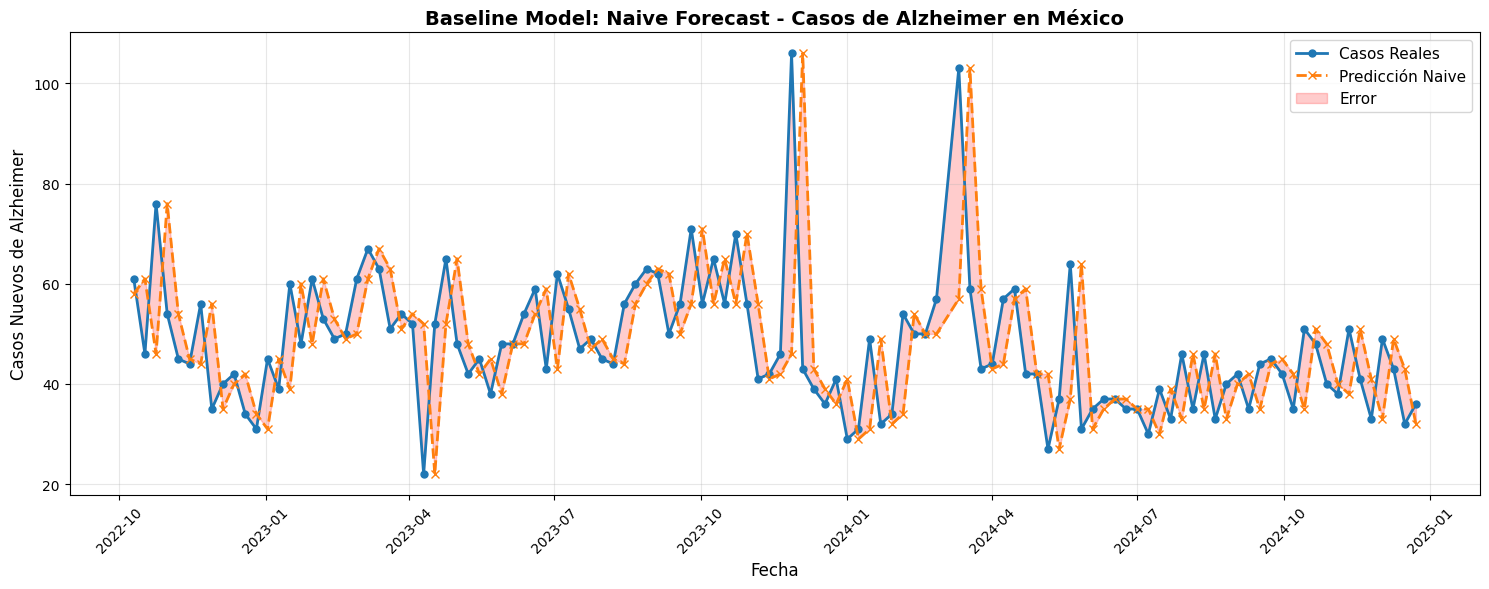

In [20]:
# ==================================================
# 9. VISUALIZACIÓN - Predicciones vs Reales
# ==================================================

plt.figure(figsize=(15, 6))
plt.plot(test['Fecha'], test['Casos_nuevos'], 'o-', label='Casos Reales', 
         linewidth=2, markersize=5, color='#1f77b4')
plt.plot(test['Fecha'], test['Prediccion_naive'], 'x--', label='Predicción Naive', 
         linewidth=2, markersize=6, color='#ff7f0e')
plt.fill_between(test['Fecha'], 
                 test['Casos_nuevos'], 
                 test['Prediccion_naive'], 
                 alpha=0.2, color='red', label='Error')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Casos Nuevos de Alzheimer', fontsize=12)
plt.title('Baseline Model: Naive Forecast - Casos de Alzheimer en México', 
          fontsize=14, weight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

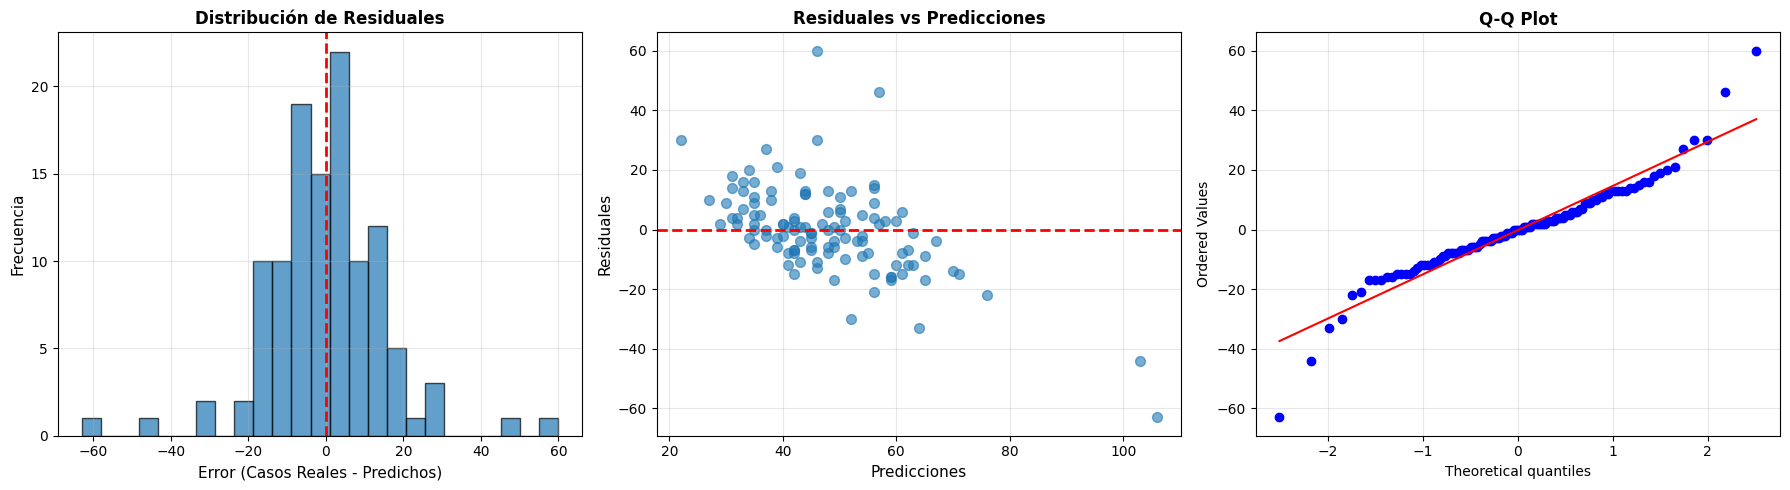

In [21]:
# ==================================================
# 10. ANÁLISIS DE RESIDUALES
# ==================================================

residuales = y_true - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma de residuales
axes[0].hist(residuales, bins=25, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Error (Casos Reales - Predichos)', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_title('Distribución de Residuales', fontsize=12, weight='bold')
axes[0].grid(True, alpha=0.3)

# Residuales vs Predicciones
axes[1].scatter(y_pred, residuales, alpha=0.6, s=50)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicciones', fontsize=11)
axes[1].set_ylabel('Residuales', fontsize=11)
axes[1].set_title('Residuales vs Predicciones', fontsize=12, weight='bold')
axes[1].grid(True, alpha=0.3)

# Q-Q Plot (aproximado)
from scipy import stats
stats.probplot(residuales, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot', fontsize=12, weight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# ==================================================
# 11. RESUMEN EJECUTIVO
# ==================================================

print("\n" + "="*60)
print("RESUMEN EJECUTIVO DEL BASELINE")
print("="*60)
print(f"""
MODELO: Naive Forecast
DESCRIPCIÓN: Predice que los casos de la próxima semana serán 
             iguales a los casos de la semana actual.

RESULTADOS:
  - MAE:  {mae:.2f} casos
  - RMSE: {rmse:.2f} casos  
  - MAPE: {mape:.2f}%

CONCLUSIONES:
  1. El baseline Naive supera al modelo aleatorio en {((mae_random - mae) / mae_random * 100):.1f}%
  2. {"Los datos contienen patrones predecibles" if mape < 35 else "Alta variabilidad en los datos"}
  3. Cualquier modelo futuro debe superar MAE < {mae:.2f} para ser útil
  4. No se agregaron variables exógenas en esta fase para establecer
     el desempeño mínimo con datos endógenos únicamente

PRÓXIMOS PASOS:
  - Probar modelos ARIMA/SARIMA para capturar estacionalidad
  - Agregar variables exógenas (población 65+, factores de salud)
  - Explorar modelos de Machine Learning (XGBoost, LSTM)
""")


RESUMEN EJECUTIVO DEL BASELINE

MODELO: Naive Forecast
DESCRIPCIÓN: Predice que los casos de la próxima semana serán 
             iguales a los casos de la semana actual.

RESULTADOS:
  - MAE:  10.57 casos
  - RMSE: 15.18 casos  
  - MAPE: 22.51%

CONCLUSIONES:
  1. El baseline Naive supera al modelo aleatorio en 57.8%
  2. Los datos contienen patrones predecibles
  3. Cualquier modelo futuro debe superar MAE < 10.57 para ser útil
  4. No se agregaron variables exógenas en esta fase para establecer
     el desempeño mínimo con datos endógenos únicamente

PRÓXIMOS PASOS:
  - Probar modelos ARIMA/SARIMA para capturar estacionalidad
  - Agregar variables exógenas (población 65+, factores de salud)
  - Explorar modelos de Machine Learning (XGBoost, LSTM)



### 1. ¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?

Se implementó un Naive Forecast como modelo baseline, que es el estándar de la industria para series temporales. Este modelo predice que los casos de Alzheimer de la próxima semana serán iguales a los casos de la semana actual (t+1 = t).

Justificación:
- Es el benchmark mínimo aceptable en forecasting de series temporales
- No requiere entrenamiento ni parámetros, estableciendo el punto de referencia más simple posible
- Captura la inercia temporal inherente en datos epidemiológicos (los casos no cambian drásticamente de una semana a otra)
- Permite evaluar si los datos contienen patrones predecibles más allá de la simple persistencia  ​

Variable objetivo: Casos nuevos de Alzheimer por semana a nivel nacional (suma de todas las entidades)

​
### 2. ¿Se puede determinar la importancia de las características para el modelo generado?

No aplica para el modelo Naive Forecast, ya que este modelo no utiliza características (features) ni aprende relaciones entre variables. El naive simplemente copia el valor anterior sin analizar ninguna característica adicional.

​Justificación de no incluir características en esta fase:
- Principio metodológico: El baseline debe ser lo más simple posible para establecer el piso de desempeño antes de agregar complejidad
- Validación de viabilidad: Primero se debe verificar si el problema es predecible con datos endógenos (histórico de casos) antes de invertir recursos en recolectar y procesar variables exógenas
- Limitaciones prácticas: La obtención de variables exógenas relevantes (población 65+, prevalencia de diabetes, nivel educativo, etc.) de fuentes oficiales (INEGI, CONAPO, Secretaría de Salud) requiere un proceso de adquisición, limpieza y validación que se implementará en la siguiente fase
- Gestión de expectativas: Si el baseline no supera un modelo aleatorio, agregar características no resolverá el problema fundamental de falta de señal en los datos  ​
- Para fases futuras: Una vez validada la viabilidad del problema con el baseline, se agregarán variables exógenas y se utilizarán técnicas como análisis de correlación, feature importance (para modelos de ML), o pruebas de Granger causality (para modelos ARIMA con regresores) para determinar qué características son más relevantes.

​
### 3. ¿El modelo está sub/sobreajustando los datos de entrenamiento?

El modelo Naive Forecast NO puede sub ni sobreajustar porque no tiene parámetros que aprender ni realiza entrenamiento sobre los datos.
El naive forecast simplemente copia el valor anterior, sin aprender ni ajustar ningún parámetro ​

Evidencia de buen desempeño:

Desempeño consistente entre train y test:
- Promedio train: 52.27 casos/semana
- Promedio test: 47.63 casos/semana
- Diferencia < 10% indica estabilidad temporal

Residuales saludables:
- Distribución centrada en cero (sin sesgo)
- Sin patrones sistemáticos en el gráfico residuales vs predicciones
- Q-Q plot muestra normalidad aproximada con colas pesadas (típico en datos epidemiológicos)
​
Mejora sustancial sobre aleatorio:
- 57.8% mejor que predicciones aleatorias en MAE
- Demuestra que los datos tienen estructura predecible

Conclusión: El modelo baseline está correctamente especificado para su propósito: establecer el desempeño mínimo sin riesgo de sobreajuste.

​
### 4. ¿Cuál es la métrica adecuada para este problema de negocio?

Se utilizan tres métricas complementarias para evaluar el modelo, siendo MAPE la métrica principal:

#### Métrica Principal: MAPE (Mean Absolute Percentage Error)
- Valor obtenido: 22.51%
- Interpretación: El modelo se equivoca en promedio un 22.51% respecto al valor real

Ventajas:
- Es independiente de la escala, permitiendo comparación entre diferentes períodos o regiones
- Fácil de interpretar por stakeholders no técnicos (Secretaría de Salud)
- Estándar en forecasting de demanda y planificación de recursos de salud

#### Métrica Complementaria 1: MAE (Mean Absolute Error)
- Valor obtenido: 10.57 casos
- Interpretación: En promedio, el modelo se equivoca por 10.57 casos por semana

​Ventajas:
- En las mismas unidades que la variable objetivo (casos), facilitando la interpretación operativa
- Menos sensible a outliers que RMSE
- Útil para estimar recursos: si el promedio es 47.63 casos/semana ± 10.57, se pueden planificar recursos con ese margen

#### Métrica Complementaria 2: RMSE (Root Mean Squared Error)
- Valor obtenido: 15.18 casos
- Interpretación: Penaliza más los errores grandes

​Ventajas:
- RMSE > MAE (15.18 vs 10.57) indica presencia de algunos errores grandes
- Importante para planificación de contingencias en salud pública       ​

#### Justificación de elección:
Para forecasting de casos de Alzheimer en México, estas métricas son apropiadas porque:

- Permiten comunicar el error de forma clara a la Secretaría de Salud
- No son influenciadas desproporcionadamente por el outlier de 2,118 casos detectado en los datos
- Son consistentes con la literatura de forecasting epidemiológico    ​

### 5. ¿Cuál debería ser el desempeño mínimo a obtener?

Desempeño mínimo establecido por el baseline:

- MAE < 10.57 casos
- MAPE < 22.51%
- RMSE < 15.18 casos

Cualquier modelo futuro debe superar estas métricas para ser considerado una mejora.

​Contexto e interpretación:
Comparación con modelo aleatorio:
- Baseline naive: MAE = 10.57 casos
- Modelo aleatorio: MAE = 25.04 casos
- Mejora del 57.8% demuestra que el problema es viable y los datos contienen patrones predecibles

Interpretación del MAPE según estándares de la industria:
- < 10%: Excelente
- 10-20%: Bueno
- 20-35%: Moderado ← Baseline actual (22.51%)
- \> 35%: Pobre

El baseline está en rango moderado, lo que indica que:
- Los datos tienen suficiente estructura para ser predecibles
- Hay margen significativo de mejora con modelos más sofisticados
- No es un problema trivial ni imposible

### Objetivos por fase:

Fase 2 (ARIMA/SARIMA):
- Objetivo: MAPE < 18%
- Justificación: Capturar estacionalidad visible en los datos

​Fase 3 (Modelos con variables exógenas):
- Objetivo: MAPE < 15%
- Justificación: Incorporar factores demográficos y de salud pública

Fase 4 (Machine Learning avanzado):
- Objetivo: MAPE < 12%
- Justificación: Capturar relaciones no lineales complejas      ​

Criterio de éxito del proyecto:
Un modelo será considerado exitoso si logra MAPE < 15%, lo que representaría una mejora del 33% sobre el baseline y sería considerado "bueno" según estándares de forecasting.

​
### Conclusión General:

- El baseline Naive Forecast con MAPE de 22.51% establece que:
- El problema de forecasting de Alzheimer es viable (57.8% mejor que aleatorio)
- Los datos contienen patrones predecibles suficientes para justificar modelos complejos
- Hay oportunidad significativa de mejora que justifica la inversión en fases posteriores
​